In [1]:
# /// script
# requires-python = ">=3.10"
# ///
from pathlib import Path
from datetime import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imageio
import skimage
%matplotlib inline

# *Intro to digital images – Global BioImaging Data Course - Pune, India*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HMS-IAC/GBI-india/blob/main/notebooks/02_Intro_to_Digital_Images.ipynb)


Welcome to the digital image chapter!  
Just like the previous notebook, it is **an interactive book**: read, explore, and **do**.

> **Why Images?**  
> Digital microscopy, image analysis, and machine learning all start with pixels.  
> Understanding that an image **is just pixel values** unlocks a world of quantitative analysis.

| Chapter | Concept | Why it matters |
|---------|---------|----------------|
| 0 | Importing modules | Using the Python ecosystem
| 1 | Pixels as Arrays | Images are numbers you can compute on |
| 2 | Loading & Display | Bring real data into NumPy, visualize it |
| 3 | Image filtering and enhancement | Gaussian blur, edge detection |
| 4 | File handlings and paths | Persist your results |


## 0. Importing Modules ‑ Using the ecosystem

**Concept.**  
`import` pulls in modules – files containing variables, functions, classes.

Benefits:

* **Don’t reinvent the wheel** – tap into 400k+ packages on PyPI.  
* Organize **your** code into logical units.  
* Share work across projects.

Pro tip: use **virtual environments** (`venv`, `conda`) to isolate dependencies.

In [ ]:
import random, statistics as stats
nums = [random.randint(1, 6) for _ in range(1000)]
print('Mean throw =', stats.mean(nums))

### ✍️ Exercise: your turn!
Import `datetime` and print today’s date in ISO format.

In [ ]:
from datetime import date
print(date.today().isoformat())

## 1. Pixels as Arrays


**Concept: Image representation as numerical arrays**

A **digital image** is nothing more than a rectangular **grid of pixels**.  
Each pixel stores one or more numbers:

| Image type | Numbers per pixel | Typical NumPy shape |
|------------|------------------|---------------------|
| Grayscale  | **1** (pixel intensity: 0–255 8-bit, 0-4095 12-bit, 0-65535 16-bit) | `(height, width)`, 2D array|
| RGB color  | **3** (R, G, B)   | `(height, width, 3)`, 3D array |

Because the grid is regular, it maps perfectly to a **NumPy array**.

**Libraries we will use**:
- `numpy` – numerical processing
- `matplotlib` – visualization
- `skimage` – image processing


**Tiny 3 × 3 example**

```python
import numpy as np
img = np.zeros((3, 3), dtype=np.uint8)
print(img)
print("Shape:", img.shape)
```

```
[[0 0 0]
 [0 0 0]
 [0 0 0]]
Shape: (3, 3)
```

---

With NumPy you can create, inspect, and transform images with ordinary array syntax (add, multiply, slice…). These tiny examples scale up seamlessly to 1024 × 1024 microscopy images.


In [44]:
#make a 9x9 checkerboard
checkBoard = np.zeros((9,9))
checkBoard[0::2, 1::2] = 1
checkBoard[1::2, 0::2] = 1

print(checkBoard)

[[0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]]


Then, import [pyplot](https://matplotlib.org/api/pyplot_api.html) and [image](https://matplotlib.org/api/image_api.html) modules from the ploting library [matplotlib](https://matplotlib.org/3.1.1/api/index.html). Using it, we can display our checkerboard array in image form:

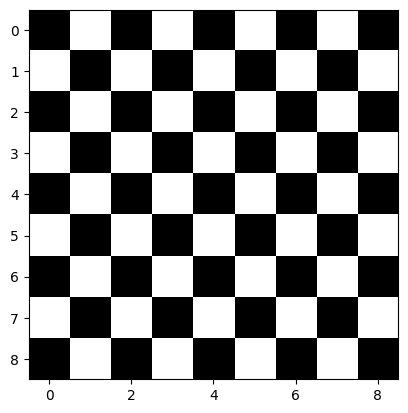

In [46]:
import matplotlib.pyplot as plt
plt.imshow(checkBoard, cmap='gray', interpolation='nearest') 
plt.show()

### ✍️ Exercise: your turn!
Create a **5 × 5** NumPy array called `blink` where the *center pixel* has value **255** and the rest are **0**.  
Print the array and its shape.

In [ ]:
# write your code here

## 2. Loading & Displaying Real Images

**Concept.**  
Real images live on disk as **PNG/JPEG/TIFF** files, and many more formats! [Bioformats](https://www.openmicroscopy.org/bio-formats/) is a library that can load many of them. Here, we'll load an image from a URL with **imageio**, convert to a NumPy array with `np.asarray`, and plot with `matplotlib`.  

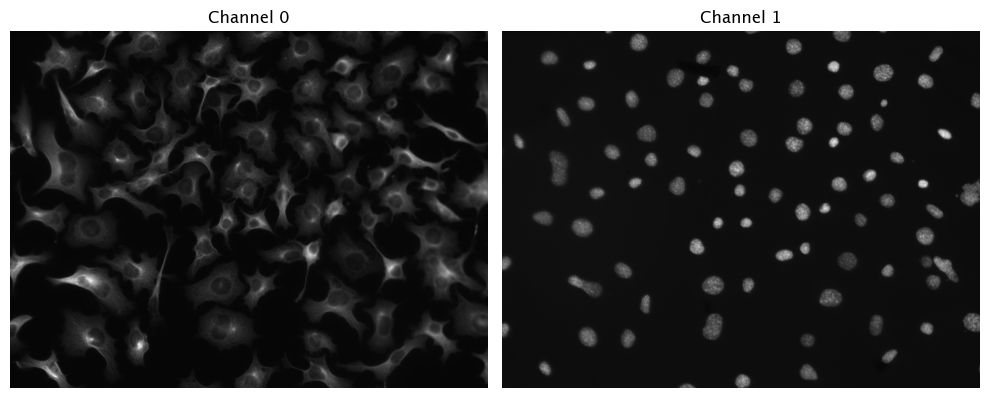

In [6]:
# load the image
try:
    from imageio.v2 import volread
except ImportError as e:
    raise ImportError(
        "Please `pip install imageio` to load cells"
    ) from e

image_url = "https://raw.githubusercontent.com/rkarmaka/sample-datasets/main/cells/cells_1.tif"
image = np.asarray(volread(image_url))

# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image[0], cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(image[1], cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

plt.tight_layout()

Let's crop the image and inspect the pixel values: 

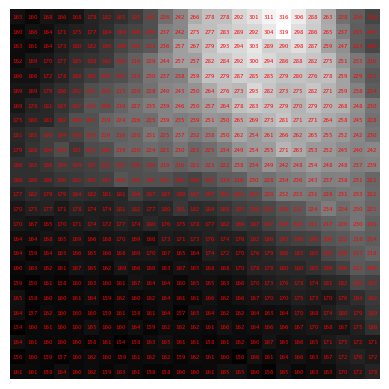

In [7]:
zoom_region = image[0, 150:175, 75:100] # around a cell boundary

plt.imshow(zoom_region, cmap='gray')
for i in range(zoom_region.shape[0]):
    for j in range(zoom_region.shape[1]):
        plt.text(j, i, f'{zoom_region[i, j]:.0f}', ha='center', va='center', color='red', fontsize=4)
plt.axis('off')
plt.show()

**Basic operations on images**

Viewing Properties

In [ ]:
print(f"Image shape: {image.shape}")
print(f"Data type: {image.dtype}")

Cropping and slicing

In [ ]:
cropped = image[0, 150:175, 75:100]
plt.imshow(cropped, cmap="gray")

Image inversion

In [ ]:
inverted = 255 - image[0]  # screens display in 8-bit RGB
plt.imshow(inverted, cmap='gray')

Rescaling intensity

In [ ]:
from skimage.exposure import rescale_intensity

rescaled = rescale_intensity(image[0], in_range=(50, 200), out_range=(0, 255))
plt.imshow(rescaled, cmap='gray')

### ✍️ Exercise: your turn!
Locate a cell by slicing the image, then print the values and the patch.

Hint: there is a cell around (100, 200)

[[112 113 111 ... 152 150 158]
 [124 119 120 ... 158 160 155]
 [134 135 137 ... 159 168 162]
 ...
 [163 159 162 ... 176 175 178]
 [163 160 156 ... 180 178 177]
 [160 163 163 ... 180 181 191]]


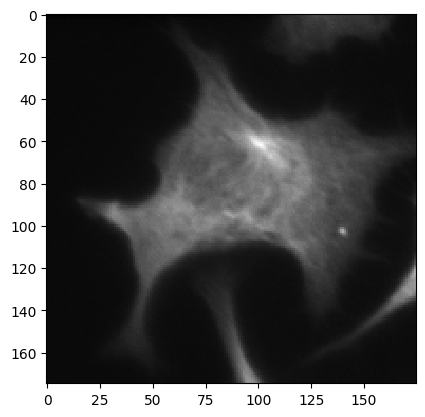

In [66]:
patch = image[0, 0:175, 50:225]
print(patch)
plt.imshow(patch, cmap='gray', interpolation='nearest') 
plt.show()

### ✍️ Exercise: your turn!
Adapt the code above to plot the composite of channels 0 and 1.

Hint: you can use `np.stack` to create the composite image.

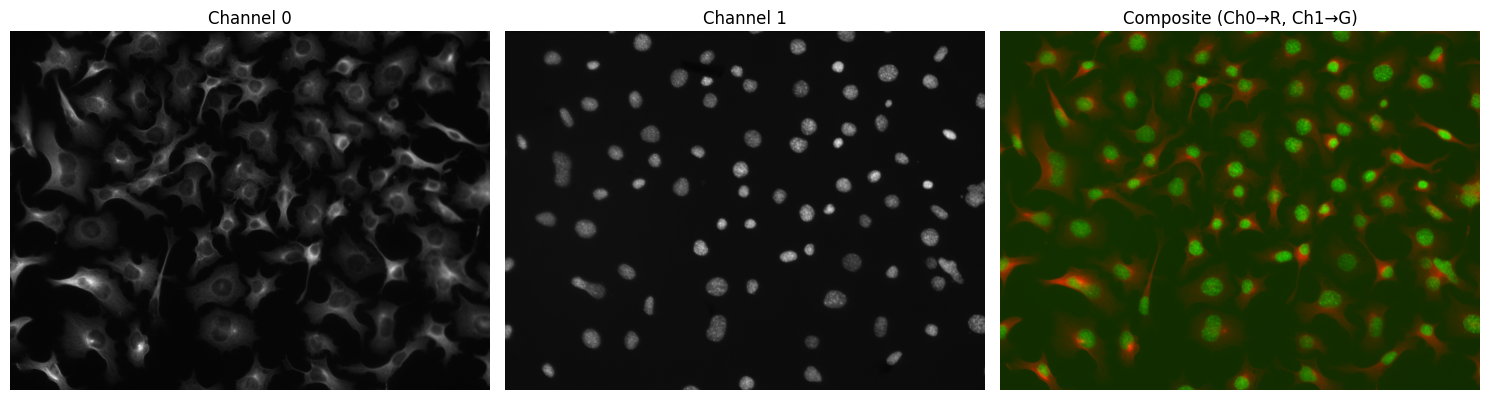

In [43]:
# write your code here

# Normalize channels to [0, 1] for display, without modifying original image
ch0 = image[0].astype(float)
ch1 = image[1].astype(float)
ch0 /= ch0.max() if ch0.max() > 0 else 1
ch1 /= ch1.max() if ch1.max() > 0 else 1

# Composite using matplotlib-compatible float RGB
composite = np.stack([ch0, ch1, np.zeros_like(ch0)], axis=-1)  # R = ch0, G = ch1, B = 0

# Plot channels and composite
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ch0, cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(ch1, cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

axes[2].imshow(composite)
axes[2].set_title("Composite (Ch0→R, Ch1→G)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Cheat-sheet: manipulating images with Numpy

**Concept:** once an image is a **NumPy array**, *vectorized* math lets you transform it lightning‑fast:


* **Add / subtract** → change **brightness**  
* **Multiply / divide** → scale **contrast**  
* **Slice rows / cols** → **crop**  
* **Logical compare** → **threshold / mask**  
* **Transpose / flip** → **mirror**  
* **Power / log** → **gamma correction**  

## 3. Image filtering and enhancement

 **Smoothing with Gaussian blur**
 
Gaussian blur is a fundamental image processing technique that:
 - Reduces noise and detail in images
 - Works by averaging each pixel with its neighbors
 - Uses a bell-shaped (Gaussian) weighting function
 - Larger blur radius = more smoothing
 - Commonly used as preprocessing for other operations

The Gaussian function gives more weight to nearby pixels and less weight to distant ones, creating a natural-looking blur effect.

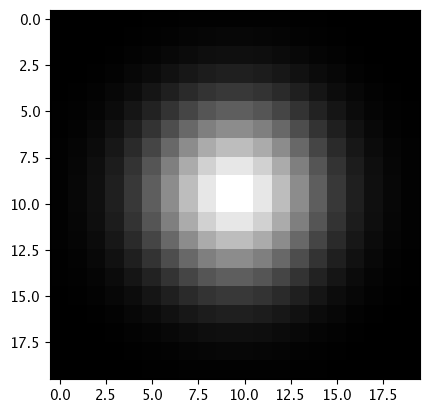

In [ ]:
x = np.linspace(-3, 3, 20)
y = np.linspace(-3, 3, 20)
X, Y = np.meshgrid(x, y)
Z = np.exp(-(X**2 + Y**2) / 2) / (2 * np.pi)
plt.imshow(Z, cmap='gray')
plt.show()

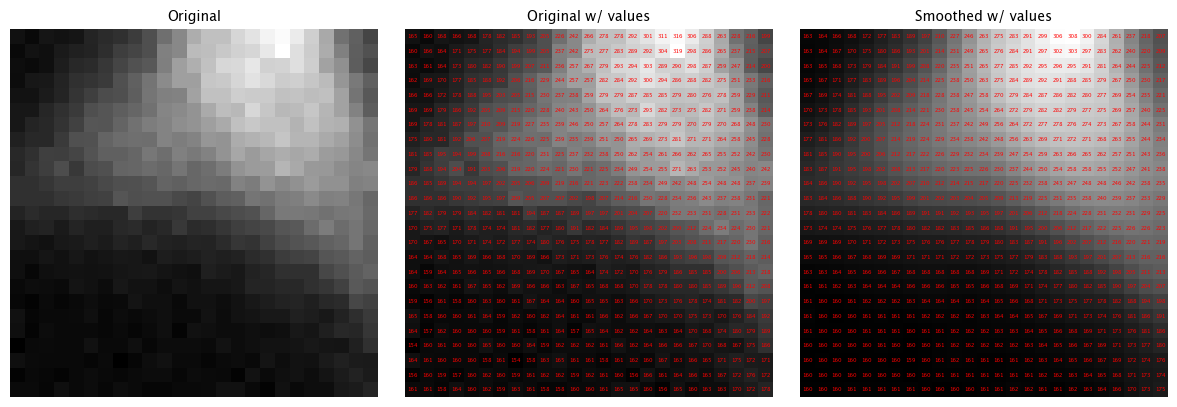

In [23]:
import matplotlib.pyplot as plt
from skimage.filters import gaussian

# around cell boundary
zoom_region = image[0, 150:175, 75:100]

# smooth the image
smooth = gaussian(zoom_region, sigma=1, preserve_range=True)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ['Original', 'Original w/ values', 'Smoothed w/ values']
images = [zoom_region, zoom_region, smooth]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    

for idx, img in enumerate([zoom_region, smooth], start=1):  # skip first image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = f'{img[i, j]:.0f}'
            axes[idx].text(j, i, val, ha='center', va='center', color='red', fontsize=4)

plt.tight_layout()
plt.show()


 **Edge detection with Sobel operator**
 
The Sobel operator is a popular edge detection algorithm that:
 - Detects edges by calculating gradients in the image
 - Uses two 3x3 kernels (one for horizontal and one for vertical edges)
 - Finds both magnitude and direction of edges
 - Commonly used in image processing and computer vision tasks

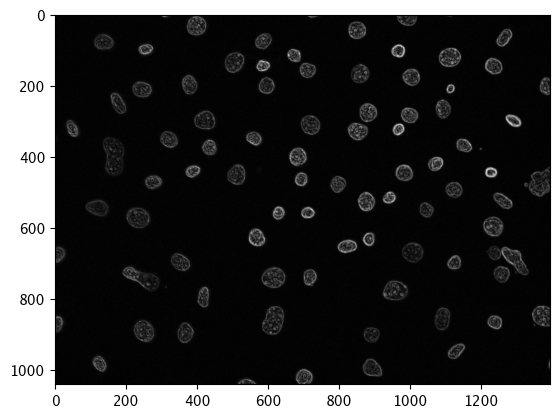

In [31]:
# the sobel operator
from skimage.filters import sobel

edges = sobel(image[1])  # on channel 1, nuclei
plt.imshow(edges, cmap='gray')

## 4. Python File Handling

**Concept.**
Files let your programs persist data.

* Use built‑in `open(path, mode)` inside a **context manager** (`with`) to ensure automatic close.  
* Modes: `'r'` read, `'w'` write (truncate), `'a'` append, `'b'` binary, `'+'` read/write.

Best practice: work with paths using `pathlib.Path`. 

In [44]:
from pathlib import Path
import time
path = Path('demo.txt')  # will create the file if it doesn't exist
with path.open('w') as f:
    f.write(f'first line {datetime.now()}\n')
    time.sleep(1)
    f.write(f'second line {datetime.now()}')

with path.open('r') as f:
    data = f.read()
    # print line by line
    for line in data.split('\n'):
        print(line)

first line 2025-06-14 13:50:56.601441
second line 2025-06-14 13:50:57.605721


Load image from a file:

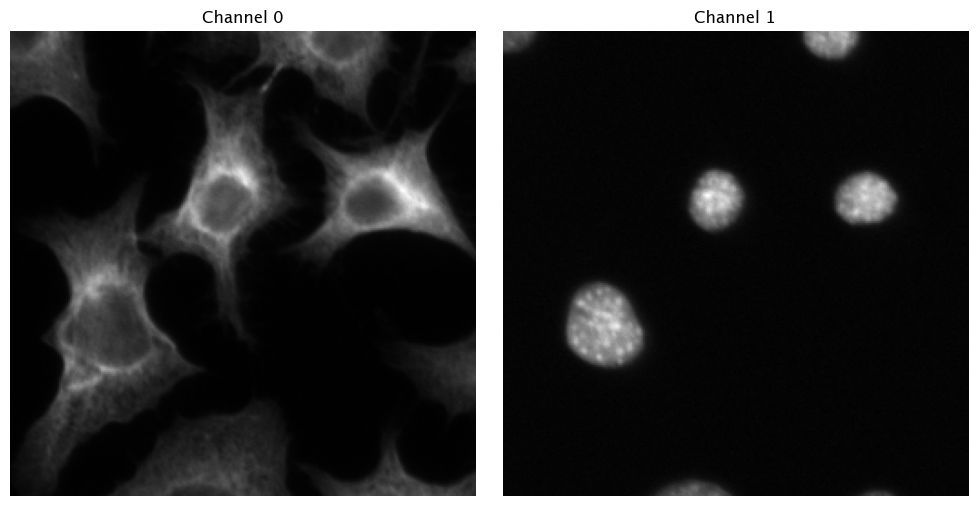

In [4]:
# load the image
image = skimage.io.imread('data/cells.tif')

# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image[0], cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(image[1], cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

plt.tight_layout()